# Machine Translation

English-German using basic language model

# 1)- Importing key modules

In [0]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [1]:
# What's life without style :). So, let's add style to our dataframes
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [0]:
import string 
import re 
from numpy import array, argmax, random, take 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
pd.set_option('display.max_colwidth', 200)

In [3]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model 
from keras import optimizers 


Using TensorFlow backend.


In [4]:
!  pip install version_information

  Created wheel for version-information: filename=version_information-1.0.3-cp36-none-any.whl size=3880 sha256=9e46becc140b401733476faab2c42fe360e415267ee79a08c1c833c2d7bf0054
  Stored in directory: /root/.cache/pip/wheels/1f/4c/b3/1976ac11dbd802723b564de1acaa453a72c36c95827e576321
Successfully built version-information


In [5]:
%reload_ext version_information
%version_information pandas,re,string, matplotlib,keras,tensorflow,numpy,sklearn

Software,Version
Python,3.6.8 64bit [GCC 8.0.1 20180414 (experimental) [trunk revision 259383]
IPython,5.5.0
OS,Linux 4.14.137+ x86_64 with Ubuntu 18.04 bionic
pandas,0.24.2
re,2.2.1
string,The 'string' distribution was not found and is required by the application
matplotlib,3.0.3
keras,2.2.5
tensorflow,1.14.0
numpy,1.16.5


# 2)- Reading Dataset

In [0]:
# function to read raw text file
def read_text(filename): 
        # open the file 
        file = open(filename, mode='rt', encoding='utf-8') 
        
        # read all text 
        text = file.read() 
        file.close() 
        return text

In [0]:
# split text into sentences 
def to_lines(text): 
      sents = text.strip().split('\n') 
      sents = [i.split('\t') for i in sents] 
      return sents

In [0]:
data = read_text("random_data.txt") 
deu_eng = to_lines(data) 
deu_eng = array(deu_eng)

In [9]:
type(deu_eng)

numpy.ndarray

In [10]:
# for english part 
deu_eng[:,0]

array(['india and japan prime ministers meet in tokyo',
       'indias new prime minister narendra modi is meeting his japanese counterpart shinzo abe in tokyo to discuss economic and security ties on his first major foreign visit since winning mays election',
       'mr modi is on a fiveday trip to japan to strengthen economic ties with the third largest economy in the world',
       ..., 'five minutes later the first mountainbikers set off',
       'bent hansen chairman of the association cycling on the grosser feldberg gave the starting orders and wished those taking part an enjoyable trip',
       'next year he hopes to have safety barriers on the course for the benefit of those taking part on the feldberg'],
      dtype='<U511')

In [11]:
# for german version of data
deu_eng[:,1]

array(['die premierminister indiens und japans trafen sich in tokio',
       'indiens neuer premierminister narendra modi trifft bei seinem ersten wichtigen auslandsbesuch seit seinem wahlsieg im mai seinen japanischen amtskollegen shinzo abe in toko um wirtschaftliche und sicherheitspolitische beziehungen zu besprechen',
       'herr modi befindet sich auf einer funftagigen reise nach japan um die wirtschaftlichen beziehungen mit der drittgroten wirtschaftsnation der welt zu festigen',
       ..., 'funf minuten spater legten die ersten mountainbiker los',
       'bent hansen vorsitzender des vereins radeln auf den groen feldberg gab die startkommandos und wunschte den teilnehmern einen schonen ausflug',
       'fur nachstes jahr hoffe er dass es gelingt die strecke zum feldberg hinauf zur sicherheit der teilnehmer zu sperren'],
      dtype='<U511')

# 3)-Text Pre-Processing

### 3.1)-Text cleaning

In [0]:
# Remove punctuation 
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]] 
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]] 

# convert text to lowercase 
for i in range(len(deu_eng)): 
    deu_eng[i,0] = deu_eng[i,0].lower() 
    deu_eng[i,1] = deu_eng[i,1].lower()

### 3.2)-Text to Sequence Conversion

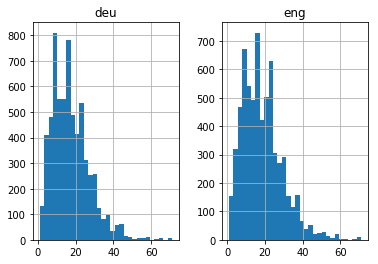

In [0]:
# empty lists 
eng_l = [] 
deu_l = [] 

# populate the lists with sentence lengths 
for i in deu_eng[:,0]: 
      eng_l.append(len(i.split())) 

for i in deu_eng[:,1]: 
      deu_l.append(len(i.split())) 

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
length_df.hist(bins = 30) 
plt.show()

the maximum length of the German sentences(target) is 73 where  max. lenth of English(input seq) is 71. But, their distribution pattern is different from each other

### 3.3)-vectorize our text data 

by using Keras’s Tokenizer()

In [13]:
# function to build a tokenizer 
def tokenization(lines): 
      tokenizer = Tokenizer() 
      tokenizer.fit_on_texts(lines) 
      return tokenizer

# prepare english tokenizer 
eng_tokenizer = tokenization(deu_eng[:, 0]) 
eng_vocab_size = len(eng_tokenizer.word_index) + 1 
eng_length = 71  

print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 7231


In [14]:
# prepare Deutch tokenizer 
deu_tokenizer = tokenization(deu_eng[:, 1]) 
deu_vocab_size = len(deu_tokenizer.word_index) + 1 
deu_length = 71 # keeping aligned with input sequence
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 9284


There is difference in amount of words in two languages.We need to encode sequence

### 3.4)-encode and pad sequences 

 pad those sequences with zeros to make all the sequences of the same length.

In [0]:
def encode_sequences(tokenizer, length, lines):          
         # integer encode sequences          
         seq = tokenizer.texts_to_sequences(lines)          
         # pad sequences with 0 values          
         seq = pad_sequences(seq, maxlen=length, padding='post')           
         return seq

# 4)-Model Building

### 4.1)- Train-test Split

80%-20%

In [0]:
from sklearn.model_selection import train_test_split 

# split data into train and test set 
train,test= train_test_split(deu_eng,test_size=0.2,random_state= 12)

### 4.2)- Defining input and target
We will encode English sentences as the input sequences and German sentences as the target sequences

In [17]:
# english version
train[:, 0]

array(['its not my responsibility',
       'meanwhile in our homes items as innocuous as floor tiles or shed roofs have routinely contained asbestos',
       'she said i keep thinking this world did not get better within these years',
       ...,
       'crops are rotting in the fields mines have been deserted and the markets have been abandoned the virus has cost the region dearly',
       'the preparations for the party are well underway in tannenwald gun club which will celebrate years since being established on to september',
       'it also means higher taxes'], dtype='<U511')

In [18]:
# english version
train[:, 1]

array(['ich bin nicht dafur verantwortlich',
       'und derweil haben so unschuldige gegenstande in unseren hausern wie fubodenplatten oder schuppendacher standardmaig asbest enthalten',
       'sie sagte ich denke immer dass diese welt in diesen jahren nicht besser geworden ist',
       ...,
       'die ernte verrottet auf den feldern die minen sind verlassen und die markte verwaist das virus hat der region schwer zugesetzt',
       'auf hochtouren laufen beim schutzenverein tannenwald die vorbereitungen fur das grundungsfest von bis september',
       'sie bedeutet auch hohere steuern'], dtype='<U511')

**apply sequence encoding on both train and validation data**

In [0]:
# prepare training data 
trainX = encode_sequences(eng_tokenizer, deu_length, train[:, 0]) 
trainY = encode_sequences(deu_tokenizer, eng_length, train[:, 1]) 

# prepare validation data 
testX = encode_sequences(eng_tokenizer, deu_length, test[:, 0]) 
testY = encode_sequences(deu_tokenizer, eng_length, test[:, 1])

In [20]:
print(trainX[:5])

[[  48   23   51 4075    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [ 567    4   86  439 5283   14 2913   14 2903 2904   64 2016 5284   17
  5285 2943   65    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [  46   26   13 1113  648   30  141   97   23   98  179  362  193   58
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0  

In [21]:
print(trainY[:5])

[[  15  184   18  272 1521    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   3 1037   49   43 6213 6214    4  753 1071   30 2751   59 6215 6216
    85 1223    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0]
 [  13   38   15  494   87   10   62  197    4  261  100   18  323  708
    16    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0  

In [22]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(5205, 71)
(5205, 71)
(1302, 71)
(1302, 71)


### 4.3)- build NMT model

In [0]:
 def build_model(in_vocab,out_vocab, in_timesteps,out_timesteps,n):   
      model = Sequential() 
      model.add(Embedding(in_vocab, n, input_length=in_timesteps,   
      mask_zero=True)) 
      model.add(LSTM(n)) 
      model.add(RepeatVector(out_timesteps)) 
      model.add(LSTM(n, return_sequences=True))  
      model.add(Dense(out_vocab, activation='softmax')) 
      return model

In [26]:
# model compilation (with 512 hidden units)
model = build_model(eng_vocab_size,deu_vocab_size, eng_length, deu_length, 512)

rms = optimizers.RMSprop(lr=0.001) 
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 71, 512)           3702272   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 71, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 71, 512)           2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 71, 9284)          4762692   
Total params: 12,663,364
Trainable params: 12,663,364
Non-trainable params: 0
_________________________________________________________________


In [28]:
filename = 'model_translate.h1' 

# set checkpoint
checkpoint = ModelCheckpoint(filename, monitor='val_loss',  
                             verbose=1, save_best_only=True, 
                             mode='min') 


# train model 
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
                    epochs=30, batch_size=512, validation_split = 0.2, 
                    callbacks=[checkpoint], verbose=1)


Train on 4164 samples, validate on 1041 samples
Epoch 1/30
4164/4164 [==============================] - 26s 6ms/step - loss: 4.6830 - val_loss: 2.3161

Epoch 00001: val_loss improved from inf to 2.31610, saving model to model_translate.h1
Epoch 2/30
4164/4164 [==============================] - 20s 5ms/step - loss: 2.2885 - val_loss: 2.2566

Epoch 00002: val_loss improved from 2.31610 to 2.25660, saving model to model_translate.h1
Epoch 3/30
4164/4164 [==============================] - 20s 5ms/step - loss: 2.2988 - val_loss: 2.2530

Epoch 00003: val_loss improved from 2.25660 to 2.25296, saving model to model_translate.h1
Epoch 4/30
4164/4164 [==============================] - 20s 5ms/step - loss: 2.3147 - val_loss: 2.2030

Epoch 00004: val_loss improved from 2.25296 to 2.20297, saving model to model_translate.h1
Epoch 5/30
4164/4164 [==============================] - 20s 5ms/step - loss: 2.2080 - val_loss: 2.0795

Epoch 00005: val_loss improved from 2.20297 to 2.07954, saving model to

# 5)-Plotting results

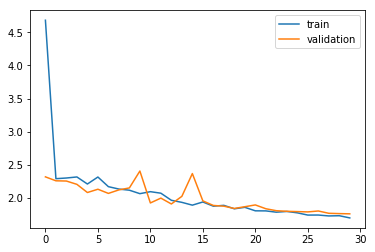

In [29]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.legend(['train','validation']) 
plt.show()

As you can see in the above plot, the validation loss kept on improving and is aligned with training sample.Hence, there is no over-fitting.

We have got a reasonable outcome with 30 epochs.

# 6)-Make Predictions

In [0]:
model = load_model('model_translate.h1') 

preds = model.predict_classes(testX.reshape((testX.shape[0], testX.shape[1])))

These predictions are sequences of integers. We need to convert these integers to their corresponding words.

### 6.1)- Convert integers to words

In [0]:
def get_word(n, tokenizer):  
      for word, index in tokenizer.word_index.items():                       
          if index == n: 
              return word 
      return None

### 6.2)-Convert predictions into text (German)

In [0]:
preds_text = [] 
for i in preds:        
       temp = []        
       for j in range(len(i)):             
            t = get_word(i[j], deu_tokenizer)             
            if j > 0:                 
                if (t==get_word(i[j-1],deu_tokenizer))or(t== None):                       
                     temp.append('')                 
                else:                      
                     temp.append(t)             
            else:                    
                if(t == None):                                   
                     temp.append('')                    
                else:                           
                     temp.append(t)        
       preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [34]:
# 1st 5 rows
pred_df.head(5)

,actual,predicted
0,wahrend die konkurrenz naher ruckt und neue technologien alte bequeme sicherheiten bedrohen ist die anstehende verhandlung der lizenzgebuhren fur die bbc mit besonderen gefahren verbunden,die und der
1,luther rabinowitz lie seine pyramide zusammenfallen,ich ist nicht
2,kurzlich erklarten die gesundheitsbehorden die krankheit sei in jeden winkel des landes vorgedrungen,die und in
3,ich billige den tweet nicht und habe ihn geloscht hie es in der spateren nachricht,die und der
4,fur den chef des oberurseler kultkiosks gehoren radtouren uber den feldberg einfach dazu,die und in


In [35]:
# print 5 rows randomly 
pred_df.sample(5)

,actual,predicted
461,das ist auch an land ein guter rat aber er ist unter wasser umso wichtiger wegen der schlechten lichtverhaltnisse,die und der
1213,charity cmt uk teilte mit dass fehldiagnosen ein haufiges problem bei menschen mit cmt sind weil so wenig uber diese krankheit bekannt ist,die und der
191,dem ist erwartungsgema nicht so,ich ist
633,es gab auf der ganzen welt nichts anderes zu sehen als ihr ungekammtes rabenschwarzes haar,die und in
637,die demonstranten fordern den rucktritt des regierungschefs dem sie wahlbetrug vorwerfen,die und der
